In [1]:
import pandas as pd
import numpy as np

# import plotly.graph_objects as go
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import coint

import statsmodels.api as sm

from scipy.stats import f

import warnings
warnings.simplefilter(action = 'ignore')

#### **0. Data**

For this essay I chose to explore **spreads** between a computed Option-Adjusted Spread (OAS) index of all **bonds** in a **BBB** rating category and a **spot Treasury curve**. The data was taken from https://fred.stlouisfed.org/series/BAMLC0A4CBBB# from 2020-12-11 to 2020-12-11.

In [4]:
data = pd.read_excel('BAMLC0A4CBBB.xlsx', sheet_name = 'Daily, Close')
data = data.dropna(axis = 0)

dates = np.array(data['observation_date'])
spreads = np.array(data['BAMLC0A4CBBB'])

data_spreads = pd.Series(spreads, index = dates)
data

,observation_date,BAMLC0A4CBBB
0,1996-12-31,0.83
2,1997-01-02,0.83
3,1997-01-03,0.83
4,1997-01-06,0.85
5,1997-01-07,0.84
...,...,...
7646,2025-12-05,1.01
7647,2025-12-08,1.00
7648,2025-12-09,1.00
7649,2025-12-10,1.00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


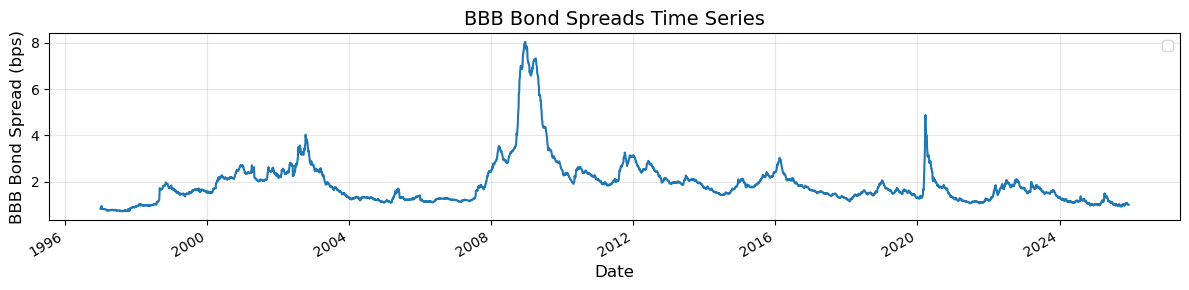

In [5]:
data_spreads.plot(figsize = (12, 3))

plt.xlabel('Date', fontsize = 12)
plt.ylabel('BBB Bond Spread (bps)', fontsize = 12)

plt.title('BBB Bond Spreads Time Series', fontsize = 14)
plt.legend()
plt.grid(True, alpha = 0.3)
plt.tight_layout()
plt.show()

#### **1. Stationarity**

We use standard ADF and KPSS tests. <br>
https://www.statsmodels.org/dev/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [8]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [9]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [10]:
adf_test(spreads)

Results of Dickey-Fuller Test:
Test Statistic                   -3.402665
p-value                           0.010868
#Lags Used                       27.000000
Number of Observations Used    7531.000000
Critical Value (1%)              -3.431219
Critical Value (5%)              -2.861924
Critical Value (10%)             -2.566974
dtype: float64


In [11]:
kpss_test(spreads)

Results of KPSS Test:
Test Statistic            0.994674
p-value                   0.010000
Lags Used                54.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Both tests indicate that BBB bonds spreads series is **NOT stationary**.

In [13]:
spreads_diff = [spreads[i+1] - spreads[i] for i in range(len(spreads)-1)]

adf_test(spreads_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.727765e+01
p-value                        5.808298e-30
#Lags Used                     1.700000e+01
Number of Observations Used    7.540000e+03
Critical Value (1%)           -3.431218e+00
Critical Value (5%)           -2.861923e+00
Critical Value (10%)          -2.566974e+00
dtype: float64


In [14]:
kpss_test(spreads_diff)

Results of KPSS Test:
Test Statistic            0.057277
p-value                   0.100000
Lags Used                40.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Now, first differences are stationary, so $\text{BBB spreads} \sim I(1)$.

#### **2. Markov Switching Models**

https://www.statsmodels.org/v0.14.4/examples/notebooks/generated/markov_regression.html#Federal-funds-rate-with-switching-intercept-and-lagged-dependent-variable

##### **2.1. MSwM with switching intercept and two regimes**

$$y_t = \mu_{s_t} + \varepsilon_t, \varepsilon_t \sim N(0, \sigma^2),$$
$s_t \in \{0, 1\}$, 
| From \ To | State 0 | State 1 |
|-----------|----------------|----------------|
| **State 0** | p₁₁ | p₁₂ |
| **State 1** | p₂₁ | p₂₂ |

In [20]:
model1 = sm.tsa.MarkovRegression(data_spreads, k_regimes = 2)
res1 = model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                 7559
Model:               MarkovRegression   Log Likelihood               -7419.675
Date:                Mon, 15 Dec 2025   AIC                          14849.349
Time:                        00:16:31   BIC                          14884.002
Sample:                             0   HQIC                         14861.244
                               - 7559                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7672      0.008    232.271      0.000       1.752       1.782
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2011      0.055    111.773      0.000       6.092       6.310
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4143      0.007     61.459      0.000       0.401       0.428
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9997      0.000   5241.212      0.000       0.999       1.000
p[1->0]        0.0087      0.006      1.441      0.150      -0.003       0.021
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: title={'center': 'Probability of being in the high-spreads regime'}>

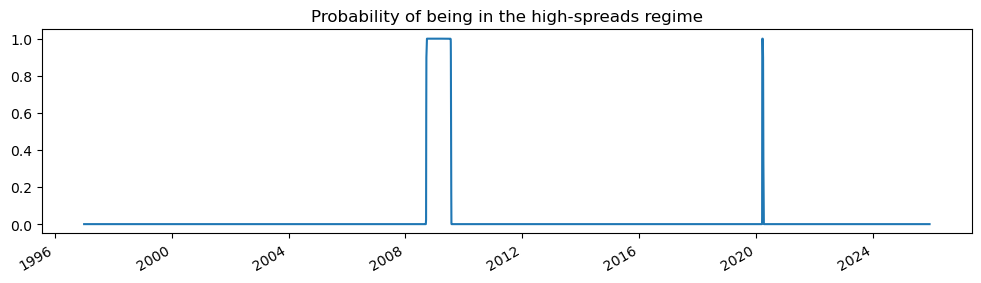

In [21]:
res1.smoothed_marginal_probabilities[1].plot(title="Probability of being in the high-spreads regime", figsize=(12, 3))

##### **2.1. MSwM with switching intercept and two regimes, and switching variance**

$$y_t = \mu_{s_t} + \varepsilon_t, \varepsilon_t \sim N(0, \sigma_{s_t}^2)$$

In [24]:
model2 = sm.tsa.MarkovRegression(data_spreads, k_regimes = 2, switching_variance = True)
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                      y   No. Observations:                 7559
Model:               MarkovRegression   Log Likelihood               -5485.645
Date:                Mon, 15 Dec 2025   AIC                          10983.289
Time:                        00:16:32   BIC                          11024.872
Sample:                             0   HQIC                         10997.563
                               - 7559                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4059      0.006    242.770      0.000       1.395       1.417
sigma2         0.0685      0.002     27.458      0.000       0.064       0.073
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6060      0.027     97.581      0.000       2.554       2.658
sigma2         1.4742      0.040     37.157      0.000       1.396       1.552
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9980      0.001   1456.902      0.000       0.997       0.999
p[1->0]        0.0031      0.001      3.036      0.002       0.001       0.005
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

<Axes: title={'center': 'Probability of being in the high-spreads regime'}>

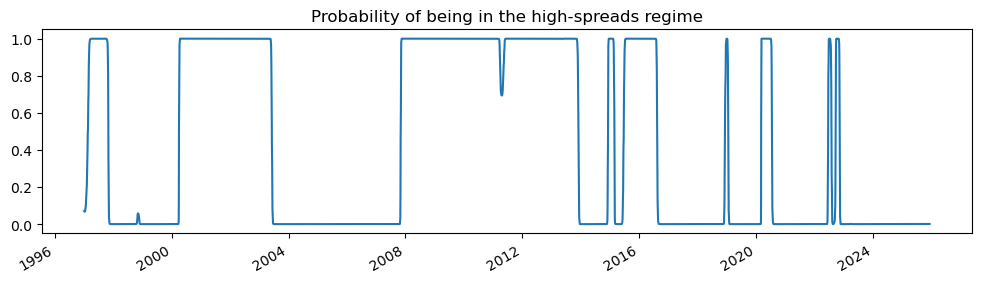

In [25]:
res2.smoothed_marginal_probabilities[1].plot(title="Probability of being in the high-spreads regime", figsize=(12, 3))

<Axes: title={'center': 'Probs of being in high-spreads, high-vol regime'}, xlabel='Date', ylabel='Probability'>

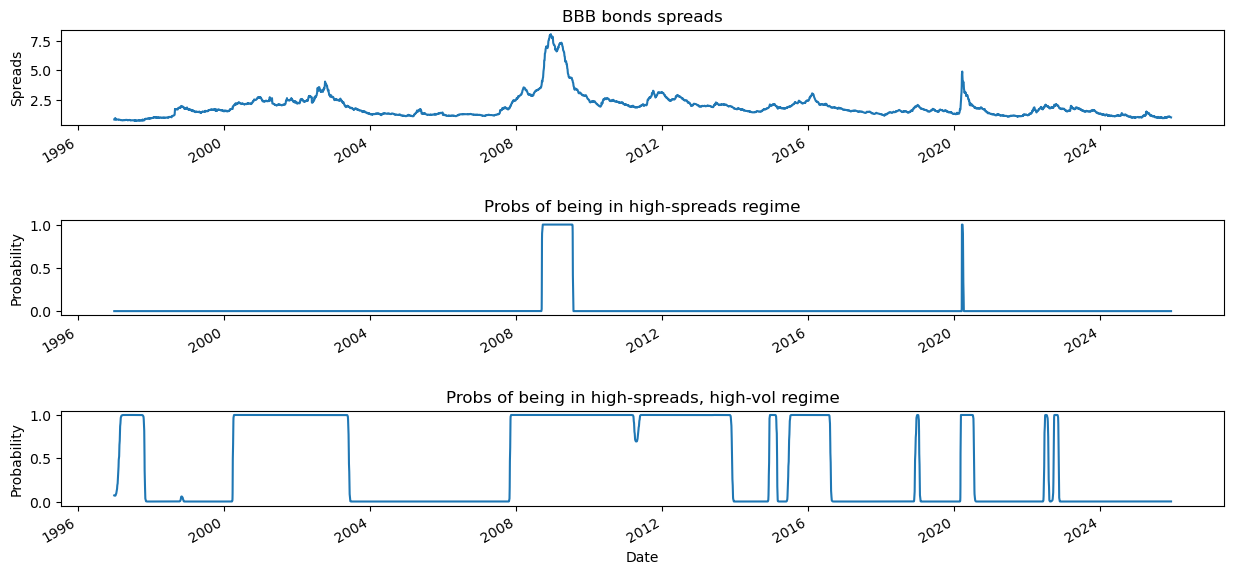

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(15, 7))
plt.subplots_adjust(hspace = 1)

data_spreads.plot(ax = axes[0], title = 'BBB bonds spreads', ylabel = 'Spreads')
res1.smoothed_marginal_probabilities[1].plot(ax = axes[1], title = 'Probs of being in high-spreads regime', ylabel = 'Probability')
res2.smoothed_marginal_probabilities[1].plot(ax = axes[2], title = 'Probs of being in high-spreads, high-vol regime', xlabel = 'Date', ylabel = 'Probability')

Based on AIC and BIC, we should choose the model with switching incercept and varicance. However, this model did not fit well numerically while making predictions, so we further use the model with switching intercept and two states.

##### **2.3. Predictive ability of the model**

##### **2.3.1. Fixed (static) forecast**

In [30]:
train_size = int(len(spreads) * 0.8)  # 80% for training
train_data = data_spreads.iloc[:train_size]
test_data = data_spreads.iloc[train_size:]
forecast_dates = dates[train_size:]

In [31]:
mod_train = sm.tsa.MarkovRegression(
    train_data, 
    k_regimes=2, 
    # switching_variance = True 
)
res_train = mod_train.fit(disp=False)

In [32]:
last_train_obs = train_data.iloc[-1]
last_train_filtered_probs = res_train.filtered_marginal_probabilities.iloc[-1].values

In [33]:
def forecast_one_step(model_results, current_regime_probs):
    
    const0, const1 = model_results.params['const[0]'], model_results.params['const[1]']
    p00 = model_results.params['p[0->0]']
    p10 = model_results.params['p[1->0]']
    
    P = np.array([[p00, 1 - p00],
                  [p10, 1 - p10]])
    
    regime_probs_next = current_regime_probs @ P
    
    forecast_regime0 = const0
    forecast_regime1 = const1
    
    forecast = regime_probs_next[0] * forecast_regime0 + regime_probs_next[1] * forecast_regime1
    
    return forecast, [forecast_regime0, forecast_regime1], regime_probs_next

##################################################################################################################

def recursive_forecasts(model_results, initial_value, initial_regime_probs, steps):
    
    forecasts = []
    all_regime_probs = [initial_regime_probs]
    current_value = initial_value
    current_probs = initial_regime_probs.copy()
    
    for step in range(steps):
        forecast, _, next_probs = forecast_one_step(model_results, current_probs)
        
        forecasts.append(forecast)
        all_regime_probs.append(next_probs)
        
        current_value = forecast
        current_probs = next_probs
    
    return forecasts, all_regime_probs

In [34]:
fixed_forecast = recursive_forecasts(res_train, last_train_obs, last_train_filtered_probs, len(test_data))[0]

fixed_rmse = 1/len(test_data) * np.sum((np.array(test_data) - np.array(fixed_forecast))**2)
fixed_rmse

0.7615449153395235

##### **2.3.2. Rolling window forecast**

In [36]:
def rolling_window_forecasts(data, test_start_idx, horizon = 4, window_size = 100):
    
    all_forecasts = []
    all_actuals = []
    forecast_dates = []
    
    for i in range(test_start_idx, len(data) - horizon):
        window_end = i
        window_start = max(0, window_end - window_size)
        
        # Training data
        train_window = data.iloc[window_start:window_end]
        train_current = train_window.iloc[1:]
        
        # Fit model
        try:
            mod_window = sm.tsa.MarkovRegression(
                train_current, 
                k_regimes=2, 
                # switching_variance = True 
            )
            res_window = mod_window.fit(disp=False)
            
            last_obs = train_window.iloc[-1]
            last_probs = res_window.filtered_marginal_probabilities.iloc[-1].values
            
            forecast, _, _ = forecast_one_step(res_window, last_probs)
            
            actual = data.iloc[i] if i < len(data) else np.nan
            
            all_forecasts.append(forecast)
            all_actuals.append(actual)
            forecast_dates.append(data.index[i])
            
        except Exception as e:
            print(f"Error at window ending {data.index[i]}: {e}")
            continue

    results = pd.DataFrame({'Date': forecast_dates, 'Actual': all_actuals, 'Forecast': all_forecasts})
    results['Error'] = results['Actual'] - results['Forecast']
        
    return results

In [37]:
rolling_results = rolling_window_forecasts(data_spreads, train_size + 1)

rolling_rmse = 1/len(rolling_results['Error']) * np.sum(rolling_results['Error']**2)
rolling_rmse

Error at window ending 2021-11-10 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-11 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-12 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-15 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-16 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-17 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-18 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-19 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-22 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11-23 00:00:00: Steady-state probabilities could not be constructed.
Error at window ending 2021-11

0.07442540285745734

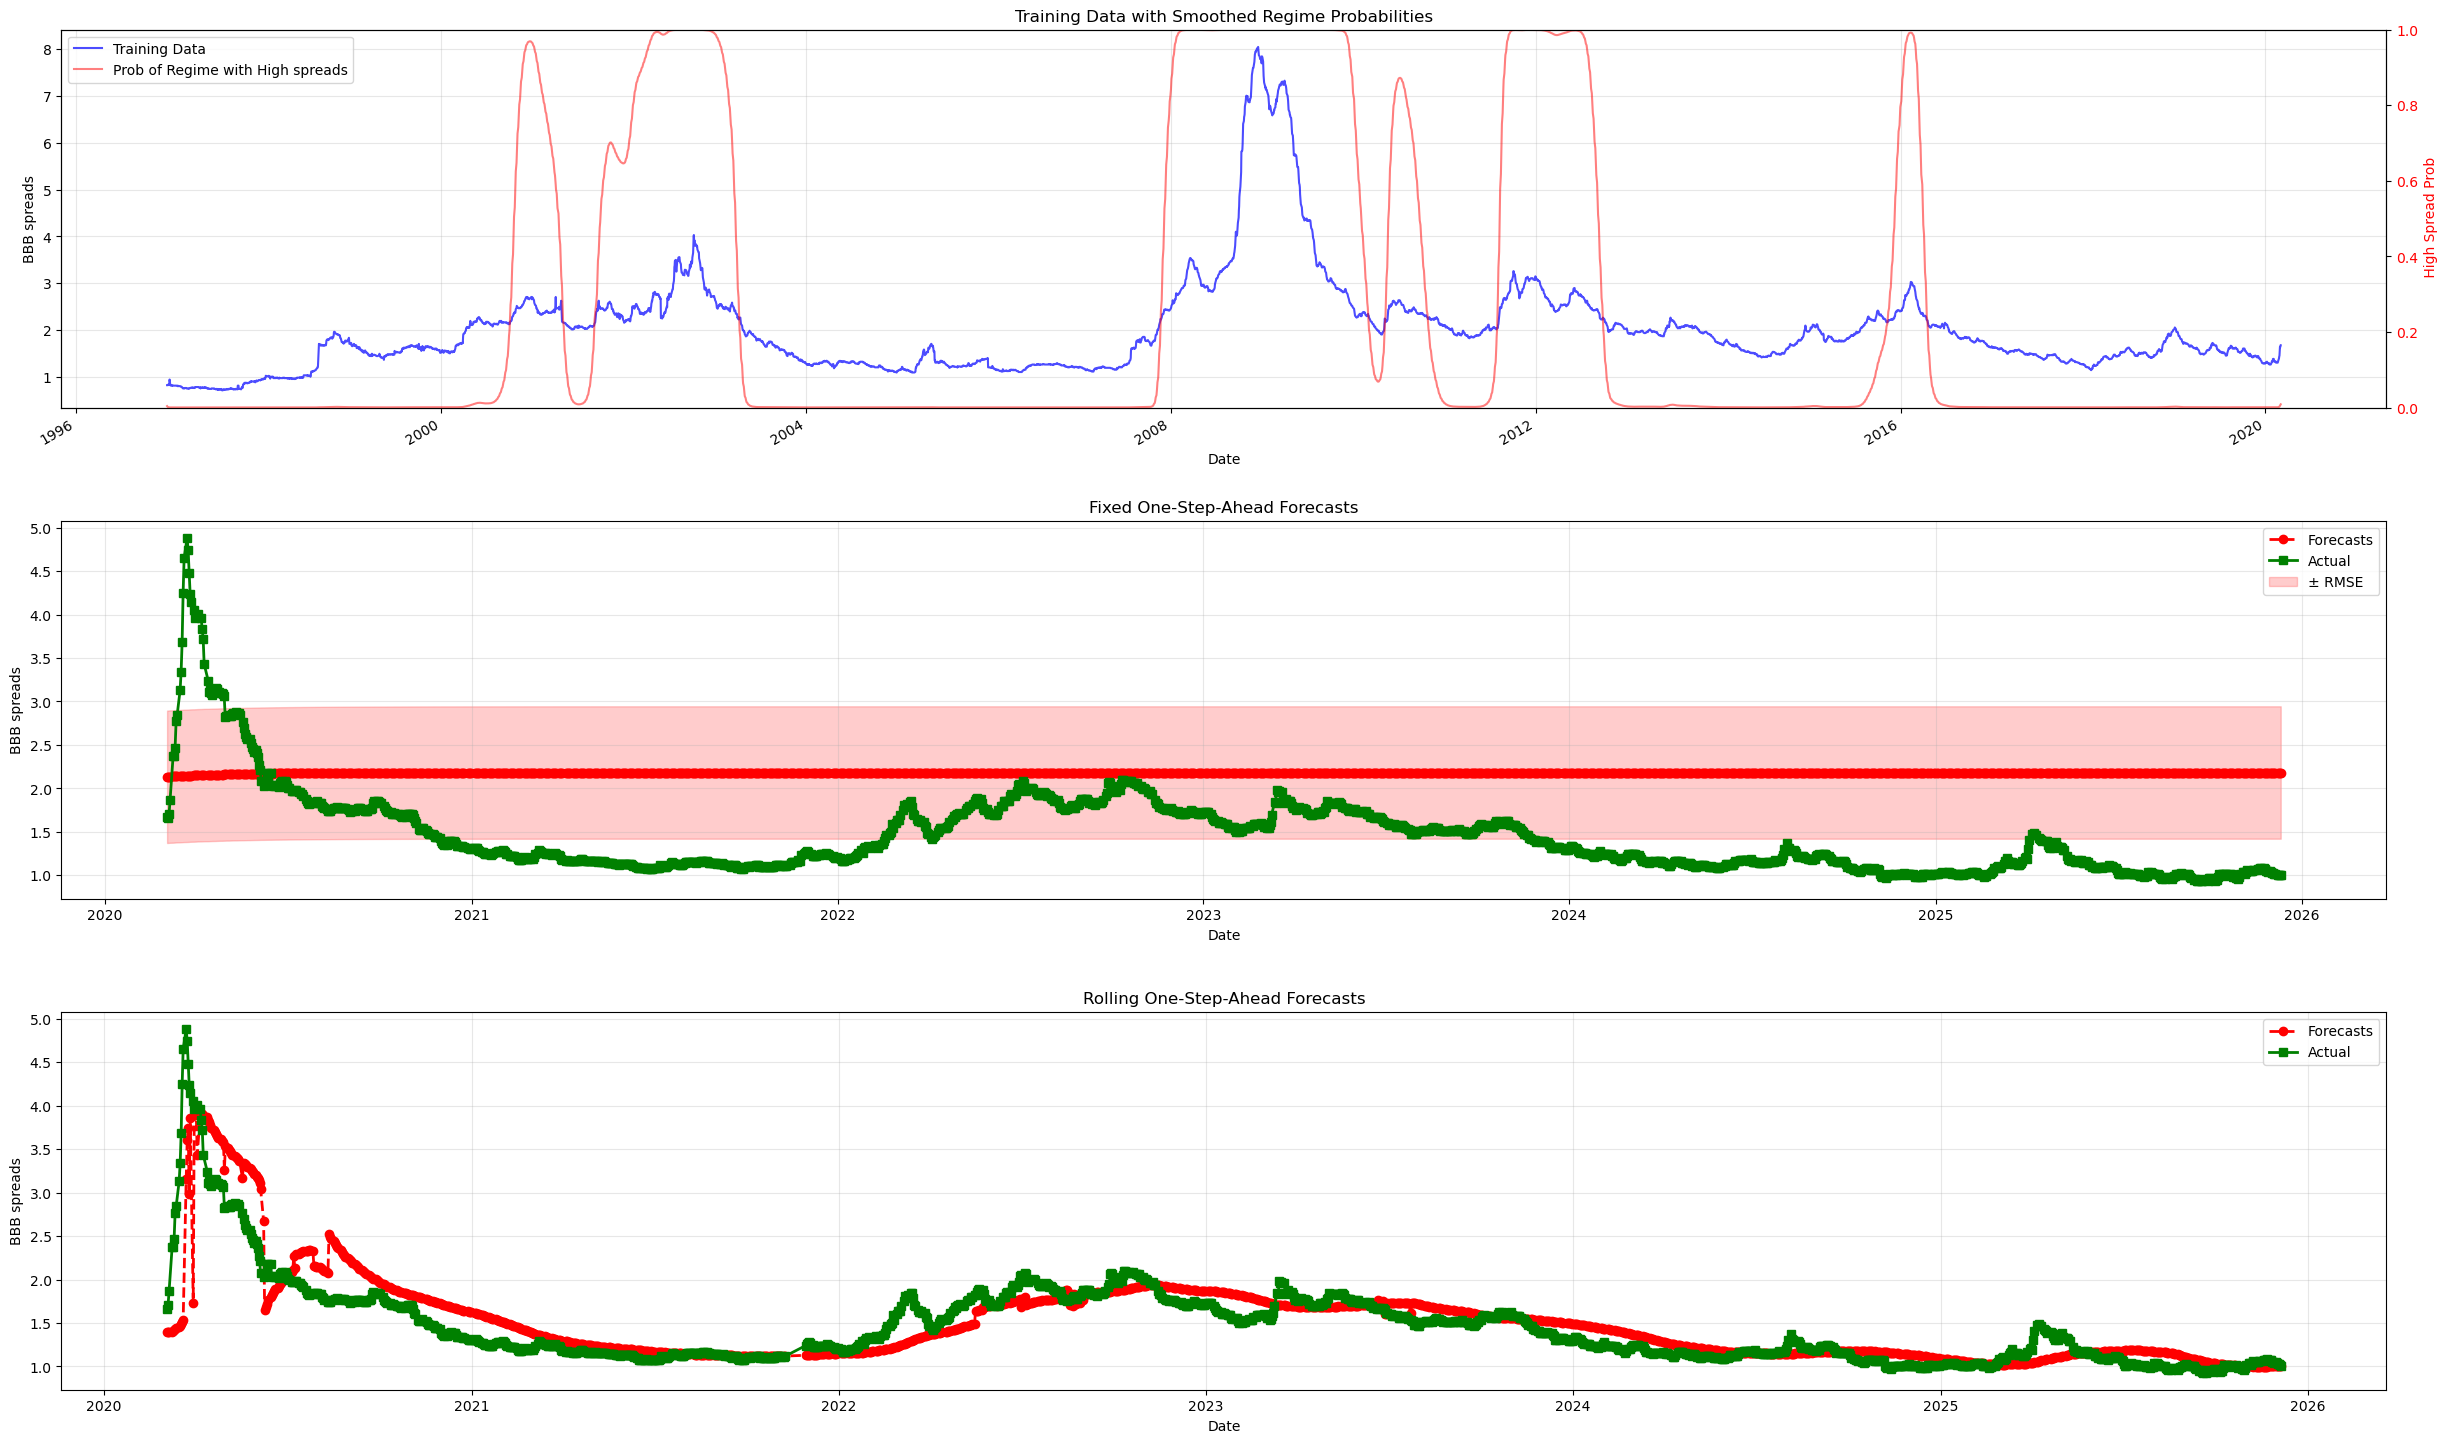

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(30, 20))
plt.subplots_adjust(hspace = 0.3)

#
ax1 = axes[0]
train_data.plot(ax = ax1, color = 'blue', alpha = 0.7, label = 'Training Data')
ax1.set_title('Training Data with Smoothed Regime Probabilities')
ax1.set_xlabel('Date')
ax1.set_ylabel('BBB spreads')
ax1.grid(True, alpha = 0.3)

ax1_twin = ax1.twinx()
res_train.smoothed_marginal_probabilities[1].plot(
    ax = ax1_twin, color = 'red', alpha = 0.5, label = 'Prob of Regime with High spreads'
)
ax1_twin.set_ylabel(' High Spread Prob', color = 'red')
ax1_twin.tick_params(axis = 'y', labelcolor = 'red')
ax1_twin.set_ylim(0, 1)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc = 'upper left')

#
ax2 = axes[1]
ax2.plot(forecast_dates, np.array(fixed_forecast), 'r--o', label = 'Forecasts', linewidth = 2, markersize = 6)
ax2.plot(forecast_dates, np.array(test_data), 'g-s', label = 'Actual', linewidth = 2, markersize = 6)

ax2.fill_between(forecast_dates, 
                 np.array(fixed_forecast) - fixed_rmse, 
                 np.array(fixed_forecast) + fixed_rmse, 
                 alpha = 0.2, color = 'red', label = '± RMSE')

ax2.set_title(f'Fixed One-Step-Ahead Forecasts')
ax2.set_xlabel('Date')
ax2.set_ylabel('BBB spreads')
ax2.legend()
ax2.grid(True, alpha = 0.3)

#
ax3 = axes[2]
ax3.plot(rolling_results['Date'], np.array(rolling_results['Forecast']), 'r--o', label = 'Forecasts', linewidth = 2, markersize = 6)
ax3.plot(rolling_results['Date'], np.array(rolling_results['Actual']), 'g-s', label = 'Actual', linewidth = 2, markersize = 6)
ax3.set_title(f'Rolling One-Step-Ahead Forecasts')
ax3.set_xlabel('Date')
ax3.set_ylabel('BBB spreads')
ax3.legend()
ax3.grid(True, alpha = 0.3)

#### **3. Structural breaks**

##### **3.1. Quandt Likelihood Ratio Test**

First, let's apply QLR Test to investigate whether there were ANY structural breaks in BBB bonds spreads since 1997.

In [42]:
data = data.copy()
data = pd.DataFrame({'spread': spreads}, index = dates)
data['time'] = np.arange(len(data))
T = len(data)

In [43]:
trim_percent = 0.15  # exclude first and last 15% of observations
trim_start = int(T * trim_percent)
trim_end = T - trim_percent

possible_breakpoints = range(trim_start, T - trim_start)
F_stats = []
break_dates = []
p_values = []

In [44]:
for i, break_idx in enumerate(possible_breakpoints):
    break_date = data.index[break_idx]
    
    pre = data.iloc[:break_idx]
    post = data.iloc[break_idx:]
    
    # Skip if either segment too small
    if len(pre) < 10 or len(post) < 10:
        continue
    
    # dummy variables for breakpoint
    D = np.zeros(T)
    D[break_idx:] = 1
    D_times_time = data['time'].values * D
    
    # unrestricted model (with break)
    X_unrestricted = np.column_stack([
        np.ones(T),
        data['time'].values,
        D,
        D_times_time
    ])
    
    y = data['spread'].values
    model_unrestricted = sm.OLS(y, X_unrestricted).fit()
    RSS_U = model_unrestricted.ssr
    
    # restricted model (no break)
    X_restricted = np.column_stack([np.ones(T), data['time'].values])
    model_restricted = sm.OLS(y, X_restricted).fit()
    RSS_R = model_restricted.ssr
    
    # Calculate F-statistic for this breakpoint
    q = 2 
    k = 4 
    F = ((RSS_R - RSS_U) / q) / (RSS_U / (T - k))
    
    F_stats.append(F)
    break_dates.append(break_date)
    
    p_val = 1 - f.cdf(F, q, T - k)
    p_values.append(p_val)

F_stats = np.array(F_stats)
p_values = np.array(p_values)


sup_F = np.max(F_stats)
sup_F

2177.472311243344

Critical values are taken from https://economia.uniroma2.it/ba/business-administration-economics/corso/asset/YTo0OntzOjI6ImlkIjtzOjQ6IjI1MzYiO3M6MzoiaWRhIjtzOjU6IjY5MTcxIjtzOjI6ImVtIjtOO3M6MToiYyI7czo1OiI5MmU0MyI7fQ==

In [46]:
# q = 2
QLR_10 = 5
QLR_5 = 5.86
QLR_1 = 7.78

Clearly, we reject $H_0$ that there are no structural break at any point in time within the sample period at all significant levels, thus there is indeed a structural break at some points of time.

##### **3.2. Chow test**

Now let's first apply Chow test with a known break date

In [50]:
break_date = '2008-09-15' # bankruptcy of Lehman Brothers

# # # or

# break_date = '2020-01-30' # The World Health Organization (WHO) declared the outbreak a public health emergency of international concern
# # (PHEIC) on 30 January 2020, and assessed it as having become a pandemic on 11 March.[3]

In [51]:
data['D'] = 0
data.loc[data.index >= break_date, 'D'] = 1
data['D_times_time'] = data['time'] * data['D']
# data

In [52]:
X_unrestricted = sm.add_constant(data[['time', 'D', 'D_times_time']])
model_unrestricted = sm.OLS(data['spread'], X_unrestricted).fit()
RSS_U = model_unrestricted.ssr
T = len(data)
k = 4

X_restricted = sm.add_constant(data[['time']])
model_restricted = sm.OLS(data['spread'], X_restricted).fit()
RSS_R = model_restricted.ssr
q = 2

F_st = ((RSS_R - RSS_U) / q) / (RSS_U / (T - k - 1))
p_value = 1 - f.cdf(F_st, q, T - k)
p_value

1.1102230246251565e-16

Based on $p-value$ which is near 0, there is strong evidence to reject $H_0$, so there was indeed a structural break, both in 2008 and 2020.

#### **4. Cointegration**

Here we will check if there is cointegration between BBB bonds spreads and the slope of the yield curve, measured by 10-Year minus 2-Year Treasury yield spread. BBB spread represents the credit risk premium. 10Y-2Y Treasury Spread is often seen as an economic growth indicator. A steep, positive slope (10Y > 2Y) typically suggests expectations of future economic growth and rising inflation. A flat curve (10Y <= 2Y) suggests market expectations of monetary policy tightening and economic slowdown. So, economic theory suggests that low BBB spreads are accompanied by steep slope of 10Y-2Y Treasury spreads, while high BBB spreads are accompanied by flat slope of 10Y-2Y Treasury spreads.

10Y-2Y Treasury Spread is also taken from Fred https://fred.stlouisfed.org/series/T10Y2Y#

In [57]:
data_T10y2y = pd.read_excel('T10Y2Y.xlsx', sheet_name = 'Daily')
data_T10y2y = data_T10y2y.dropna()

T10y2y = np.array(data_T10y2y['T10Y2Y'])

First step is to test the order of integration.

In [59]:
adf_test(T10y2y) 

Results of Dickey-Fuller Test:
Test Statistic                   -1.785935
p-value                           0.387466
#Lags Used                       26.000000
Number of Observations Used    7215.000000
Critical Value (1%)              -3.431257
Critical Value (5%)              -2.861941
Critical Value (10%)             -2.566983
dtype: float64


T10y2y spreads are not stationary.

In [61]:
T10y2y_diff = [T10y2y[i+1] - T10y2y[i] for i in range(len(T10y2y)-1)]
adf_test(T10y2y_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.591145e+01
p-value                        8.114754e-29
#Lags Used                     2.500000e+01
Number of Observations Used    7.215000e+03
Critical Value (1%)           -3.431257e+00
Critical Value (5%)           -2.861941e+00
Critical Value (10%)          -2.566983e+00
dtype: float64


But the first differences are stationary. So both BBB-spreads and T10y2y spreads are $\sim I(1)$.

In [63]:
data = pd.read_excel('BAMLC0A4CBBB.xlsx', sheet_name = 'Daily, Close')
data = data.dropna(axis = 0)

In [64]:
merged_df = pd.merge(data, data_T10y2y, on = 'observation_date', how = 'inner')  # keeps only matching dates
merged_df

,observation_date,BAMLC0A4CBBB,T10Y2Y
0,1996-12-31,0.83,0.55
1,1997-01-02,0.83,0.57
2,1997-01-03,0.83,0.57
3,1997-01-06,0.85,0.57
4,1997-01-07,0.84,0.59
...,...,...,...
7227,2025-12-05,1.01,0.58
7228,2025-12-08,1.00,0.60
7229,2025-12-09,1.00,0.57
7230,2025-12-10,1.00,0.59


https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.coint.html <br>
$H_0$ is no cointegraion.

In [66]:
coint_result1 = coint(merged_df['BAMLC0A4CBBB'], -merged_df['T10Y2Y']) 
coint_result1

(-3.96521793168495,
 0.008044848715748038,
 array([-3.89795522, -3.33697512, -3.04503658]))

We reject $H_0$, since $p-value$ is near 0. thus, there is cointegration between BBB-spreads and T10y2y spreads.